In [1]:
from SimPEG import Mesh, Directives, Maps, InvProblem, Optimization, DataMisfit, Inversion, Utils, Regularization
import SimPEG.PF as PF
from SimPEG.Utils import speye, kron3, sdiag, mkvc
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.spatial import cKDTree
from matplotlib.patches import Rectangle
from GeoToolkit.Mag import Mag, Simulator
from discretize.utils import meshutils
import scipy.sparse as sp                   
import shutil


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy
numpy.__version__


'1.15.3'

In [11]:
# # STEP 1: Setup and data simulation # #

# Magnetic inducing field parameter (A,I,D)
B = [50000, 90, 0]
midy = 62
padding_distance = [[50, 50], [50, 50], [200, 50]]

# Create a mesh
dx = 5.
core_cell_size = [dx, dx, dx]
octree_levels_padding = [1,3]
octree_levels_obs = [10,4]
octree_levels_topo = [0,2] 

# Create and array of observation points
xr = np.linspace(-60., 60., 21)
yr = np.linspace(-60., 60., 21)
X, Y = np.meshgrid(xr, yr)

# Move the observation points 5m above the topo
Z = np.zeros_like(X) + dx

# Create a gravity
xyzLoc = np.c_[mkvc(X), mkvc(Y), mkvc(Z)]
rxLoc = PF.BaseGrav.RxObs(xyzLoc)
srcField = PF.BaseGrav.SrcField([rxLoc])
surveyGrav = PF.BaseGrav.LinearSurvey(srcField)

# Create a flat topo
xr = np.linspace(-150, 150, 21)
yr = np.linspace(-150, 150, 21)
X, Y = np.meshgrid(xr, yr)
Z = np.zeros_like(X)
topo = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]

# Create an octree mesh
mesh = meshutils.mesh_builder_xyz(
    topo, core_cell_size, padding_distance=padding_distance,
    base_mesh=None,
    mesh_type='TREE',
)
mesh = meshutils.refine_tree_xyz(
    mesh, topo, octree_levels=octree_levels_topo, 
    method='surface', finalize=False
)
mesh = meshutils.refine_tree_xyz(
    mesh, xyzLoc, octree_levels=octree_levels_obs, 
    octree_levels_padding=octree_levels_padding, 
    method='surface', finalize=True
)


# xlim = 80
# a = np.r_[-xlim, mesh.vectorCCy[midy]]
# b = np.r_[xlim, mesh.vectorCCy[midy]]

In [12]:
# We can now create a density model and generate data
# Here a simple block in half-space
corners = [np.r_[-10,-10,-35], np.r_[14,14,-10]]
ind = Utils.ModelBuilder.getIndicesBlock(corners[0], corners[1], mesh.gridCC)

actv = Utils.surface2ind_topo(mesh, topo, 'CC')

# Create active map to go from reduce space to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)
nC = int(actv.sum())

den = np.zeros(mesh.nC)
den[ind] = 0.7
den = den[actv]


In [13]:
# Create reduced identity map
idenMap = Maps.IdentityMap(nP=nC)

# Create the forward problem (forwardOnly)
probGrav = PF.Gravity.GravityIntegral(mesh, rhoMap=idenMap, actInd=actv,
                                      )

# Pair the surveyGrav and problem and compute data
surveyGrav.pair(probGrav)
nD = surveyGrav.nD
d_gz = probGrav.fields(den)


# Add noise and uncertainties
# We add some random Gaussian noise (1nT)
np.random.seed(1)
wd = np.ones(len(d_gz))*0.005
noise = wd * np.random.randn(nD)
# Assign flat uncertainties
surveyGrav.dobs = d_gz + noise
surveyGrav.std = wd


Begin linear forward calculation: z
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Linear forward calculation ended in: 3.318681001663208 sec


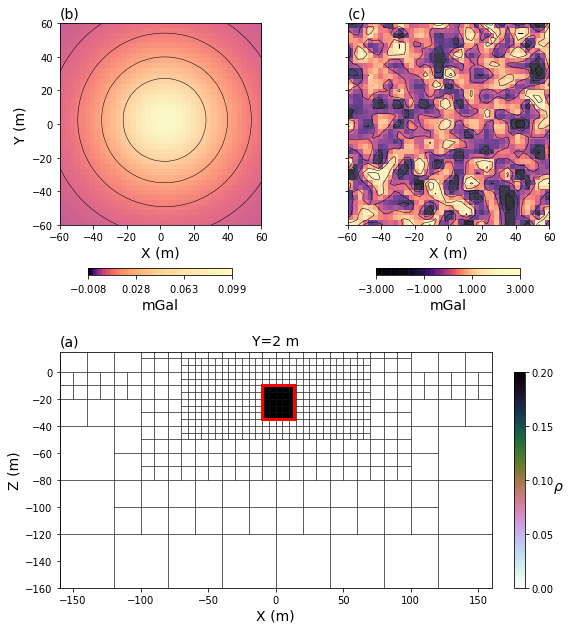

In [14]:

def plot_results(model, grid=False, figName="PF_Synthetic_True_data_model.png"):
    contours = [0.01]
    xlim = 160.
    midy = int(np.searchsorted(mesh.vectorCCy, 0))
    fig = plt.figure(figsize=(8, 8))
    ax3 = plt.axes([0., 0.5, 0.5, .5])

    dpred = surveyGrav.dpred(model)
    vmin, vmax = surveyGrav.dobs.min(), surveyGrav.dobs.max()
    X, Y, d_grid, im, CS = Simulator.plotDataHillside(
                            surveyGrav.srcField.rxList[0].locs[:,0],
                            surveyGrav.srcField.rxList[0].locs[:,1], 
                            dpred , distMax=200, minCurvature=False,
                              cmap='magma', resolution=3., axs=ax3, 
                                vmin=vmin, vmax=vmax,
                              clabel=False, contours=np.r_[5e-4, 2e-3,  5e-3, 0.01, 0.02, 0.04],  
                              alpha=0.8, alphaHS=0, ve=1., azdeg=30, altdeg=30)


    cbar = plt.colorbar(im, ticks=np.linspace(vmin,vmax, 4),
                format="${%.3f}$", shrink=0.5, orientation='horizontal')
    cbar.set_label("mGal", rotation=0, size=14)
    ax3.set_xlabel('X (m)', size=14)
    ax3.set_ylabel('Y (m)', size=14)
    ax3.set_aspect('equal')
    # ax3.set_xlabel("")
    ax3.set_title("(b)", loc='left', size=14)
    # ax3.set_xticks([])
    pos = ax3.get_position()
    ax3.set_position([pos.x0, pos.y0, pos.height, pos.width])

    ax3 = plt.axes([0.5, 0.5, 0.5, .5])
    vmin, vmax = -3,3
    X, Y, d_grid, im, CS = Simulator.plotDataHillside(
                            surveyGrav.srcField.rxList[0].locs[:,0],
                            surveyGrav.srcField.rxList[0].locs[:,1], 
                            (surveyGrav.dobs - dpred)/surveyGrav.std , distMax=200, minCurvature=False,
                              cmap='magma', resolution=3., axs=ax3, 
                                vmin=vmin, vmax=vmax,
                              clabel=False, contours=np.r_[-3, -2, -1, 0, 1,2,3],  
                              alpha=0.8, alphaHS=0, ve=1., azdeg=30, altdeg=30)

    cbar = plt.colorbar(im, ticks=np.linspace(vmin,vmax, 4),
                format="${%.3f}$", shrink=0.5, orientation='horizontal')
    cbar.set_label("mGal", rotation=0, size=14)
    ax3.set_xlabel('X (m)', size=14)
    ax3.set_ylabel('', size=14)
    ax3.set_aspect('equal')
    # ax3.set_xlabel("")
    ax3.set_yticklabels([])
    ax3.set_title("(c)", loc='left', size=14)
    # ax3.set_xticks([])
    pos = ax3.get_position()
    ax3.set_position([pos.x0, pos.y0, pos.height, pos.width])

    # Plot the model
    ax2 = plt.axes([0.05, -0.175, 0.75, .75])
    vmin, vmax = model.min(), model.max()
    im1 = mesh.plotSlice(
        actvMap * model, ind=midy, normal='Y', ax=ax2,
        pcolorOpts={"cmap":"cubehelix_r","clim":[vmin,vmax]}, clim=[vmin, vmax], grid=grid) 
    # cbar.set_label("$\kappa_e$", rotation=0, size=14)
    ax2.set_aspect('equal')
    ax2.set_xlim([-xlim, xlim])
    ax2.set_ylim([-xlim, 15])
    ax2.grid(False)

    # for midx in locx:
    ax2.add_patch(Rectangle(corners[0][::2],corners[1][0] - corners[0][0],corners[1][2] - corners[0][2], facecolor = 'none', edgecolor='r', linewidth=3))
    # ax2.grid(color='w', linestyle='--', linewidth=0.5)
    loc = ax2.get_position()
    ax2.set_position([loc.x0+0.025, loc.y0+0.025, loc.width, loc.height])
    ax2.set_xlabel('X (m)', size=14)
    ax2.set_ylabel('Z (m)', size=14)
    ax2.set_title("(a)", loc='left', size=14)
    ax2.set_title("Y=%.0f" % mesh.vectorCCy[midy] + " m", loc='center', size=14)

    pos = ax2.get_position()
    cbarAxis = plt.axes([pos.x0+0.44, pos.y0, pos.height, pos.width*0.5])
    cbarAxis.axis('off')
    cbar = plt.colorbar(im1[0], ax = cbarAxis, ticks=np.linspace(model.min(), model.max(), 5),
                format="%.1f", orientation='vertical')
    cbar.set_ticklabels(["%.2f" % ii for ii in np.linspace(0, 0.2, 5).tolist()]
    )
    cbar.set_label("$\\rho$", rotation=0, size=14)
    # "cubehelix_r"

    plt.savefig(figName, bbox_inches='tight', dpi=300)
    
plot_results(den, grid=True, figName="PF_Synthetic_True_data_model.png")

# Run inversion with Tikhonov regularization (p=2)
$$
    \phi_x = \sum_i w_i^2\frac{\left(\frac{\partial m_i}{\partial x}\right)^2}{[\left(\frac{\partial m_i}{\partial x}\right)^2 + \epsilon^2]^{1-p/2}} \\
    = \| (\mathbf{A_c^f}\:\mathbf{W})\:\mathbf{G}\:\mathbf{m}\|^2
$$

where $\mathbf{W}$ contain cells weights (sensitivity, volume) interpolated to cell faces by the averaging matrix $\mathbf{A_c^f}$

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.17e+09  4.32e+03  2.94e-12  4.32e+03    1.05e+02      0              
   1  5.87e+08  2.03e+03  1.99e-07  2.15e+03    9.76e+01      0              
   2  2.94e+08  1.69e+03  6.03e-07  1.87e+03    9.29e+01      0   Skip BFGS  
   3  1.47e+08  1.35e+03  1.43e-06  1.56e+03    9.07e+01      0   Skip BFGS  
   4  7.34e+07  1.06e+03  2.85e-06  1.27e+03    8.56e+01      0   Skip BFGS  
   5  3.67e+07  8.40e+02  5.03e-06  1.02e+03    7.98e+01      0   Skip BFGS  
   

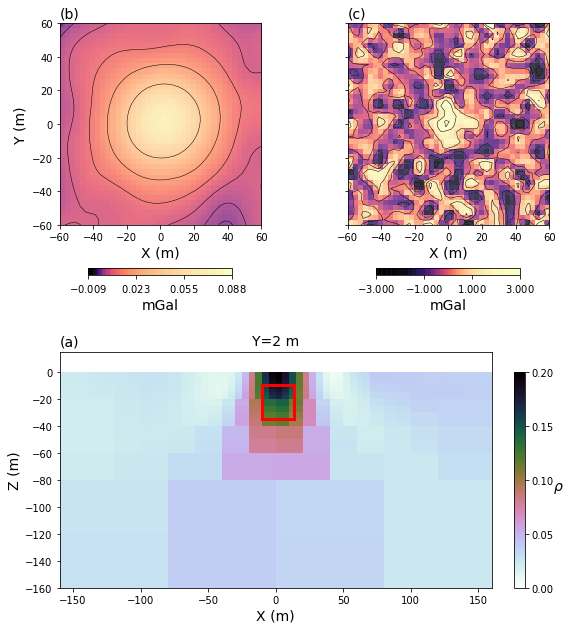

In [7]:
# Create sensitivity eights
wr = probGrav.getJtJdiag(np.ones(nC))**0.5
wr = (wr/np.max(wr))

# Create a regularization
reg_Tikhonov = Regularization.Tikhonov(mesh, indActive=actv, mapping=idenMap)
reg_Tikhonov.cell_weights = wr/mesh.vol[actv] # Normalize weights by volume because already in the reg
reg_Tikhonov.alpha_s = 0
reg_Tikhonov.mref = np.zeros(nC)


# Data misfit function
dmis = DataMisfit.l2_DataMisfit(surveyGrav)
dmis.W = 1./surveyGrav.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=-1., upper=1.,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg_Tikhonov, opt)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e+1)
chiTarget = Directives.TargetMisfit()
betaCool = Directives.BetaSchedule(coolingFactor = 2., coolingRate = 1)

update_Jacobi = Directives.UpdatePreconditioner()
inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, betaCool, chiTarget, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
mrec_Tikhonov = inv.run(m0)

plot_results(mrec_Tikhonov, figName="Grav_Inv_Tikhonov.png")

The main issues with the usual gradients operators are
- Higher gradient penalty at each octree level change
- Difficult to apply sparse norms (scaling $\phi_s$ and dependency between $\epsilon$ and the cell width)

$$
  \phi_x  = \sum_i w_i^2 \partial x_i^{(p-2)} \frac{\left(\frac{\partial m_i}{\partial x_i}\right)^2}{[\partial m_i^2 + (\partial x_i\:\epsilon)^2]^{(1-p/2)}}
$$


# Invert once more with Simple regularization (no length scales)

$$
    \phi_x = \sum_i w_i^2 \frac{\partial m_i^2}{[\partial m_i^2 + \epsilon^2]^{1-p/2}} \\
    = \| (\mathbf{A_c^f}\:\mathbf{W})\:\mathbf{D}\:\mathbf{m}\|^2
$$

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.70e+08  4.32e+03  0.00e+00  4.32e+03    1.05e+02      0              
   1  8.52e+07  2.08e+03  1.36e-06  2.19e+03    9.99e+01      0              
   2  4.26e+07  1.73e+03  4.10e-06  1.91e+03    9.71e+01      0   Skip BFGS  
   3  2.13e+07  1.39e+03  9.91e-06  1.60e+03    9.28e+01      0   Skip BFGS  
   4  1.07e+07  1.08e+03  2.03e-05  1.29e+03    8.67e+01      0   Skip BFGS  
   5  5.33e+06  8.42e+02  3.63e-05  1.03e+03    7.99e+01      0   Skip BFGS  
   

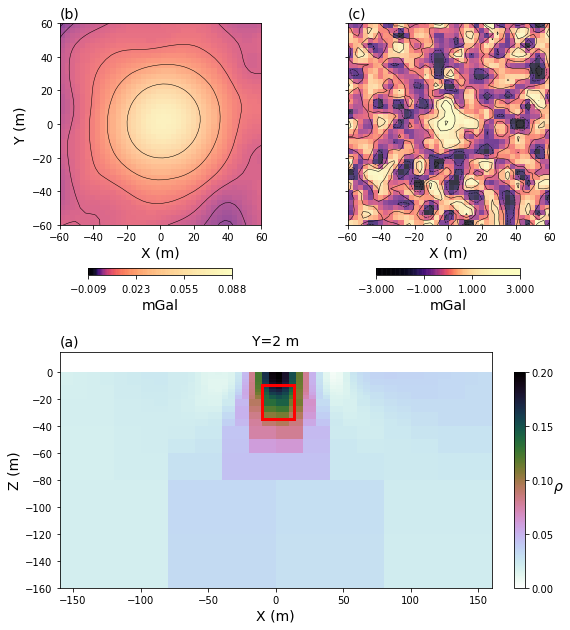

In [8]:
# Create a regularization function, in this case l2l2
wr = probGrav.getJtJdiag(np.ones(nC))**0.5
wr = (wr/np.max(wr)) 


reg_Simple = Regularization.Simple(mesh, indActive=actv, mapping=idenMap)
reg_Simple.alpha_s = 0
reg_Simple.cell_weights = wr
reg_Simple.mref = np.zeros(nC)


# Data misfit function
dmis = DataMisfit.l2_DataMisfit(surveyGrav)
dmis.W = 1./surveyGrav.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=-1., upper=1.,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg_Simple, opt)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e+1)
chiTarget = Directives.TargetMisfit()
betaCool = Directives.BetaSchedule(coolingFactor = 2., coolingRate = 1)

update_Jacobi = Directives.UpdatePreconditioner()
inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, betaCool, chiTarget, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
mrec_Simple = inv.run(m0)

plot_results(mrec_Simple, figName="Grav_Inv_Simple_half.png")

Removing the length scales reduces the impact of increase in cell size, but the model is now mesh dependent.  

# Add the length scales back in the gradient operators, but computed on hanging faces

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.76e+09  4.32e+03  0.00e+00  4.32e+03    1.05e+02      0              
   1  8.78e+08  1.23e+03  1.85e-07  1.40e+03    9.57e+01      0              
   2  4.39e+08  1.02e+03  3.16e-07  1.16e+03    9.08e+01      0   Skip BFGS  
   3  2.20e+08  9.06e+02  4.89e-07  1.01e+03    8.71e+01      0   Skip BFGS  
   4  1.10e+08  7.63e+02  9.12e-07  8.63e+02    8.20e+01      0              
   5  5.49e+07  5.99e+02  1.88e-06  7.02e+02    7.87e+01      0   Skip BFGS  
   

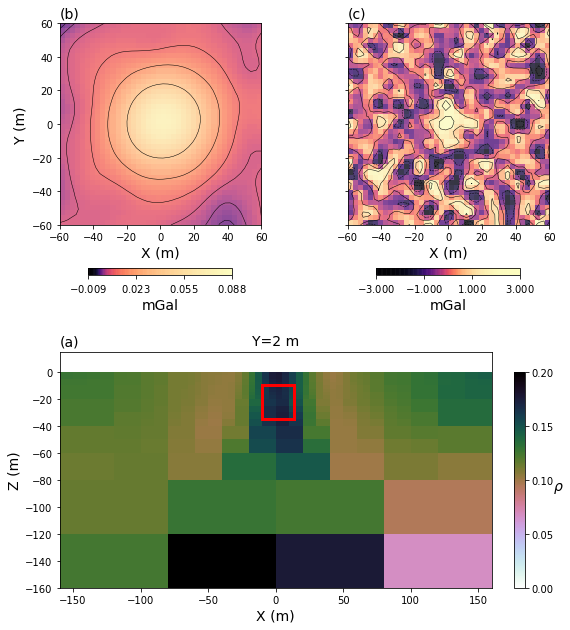

In [9]:
# Create a regularization function, in this case l2l2
wr = probGrav.getJtJdiag(np.ones(nC))**0.5
wr = (wr/np.max(wr)) 


reg_Tikh_face = Regularization.Simple(mesh, indActive=actv, mapping=idenMap)
reg_Tikh_face.alpha_s = 0
reg_Tikh_face.cell_weights = wr
reg_Tikh_face.mref = np.zeros(nC)

# Create a gradient operator with 1/dx on hanging faces X
Pac = Utils.speye(mesh.nC)[:, actv]
indActive_Fx = (
    (mesh._aveCC2FxStencil() * actv) >= 1
)
Pafx = (
    Utils.speye(mesh.ntFx)[:, indActive_Fx]
)
reg_Tikh_face.regmesh._cellDiffxStencil = Pafx.T * sdiag(mesh._aveCC2FxStencil() * (1./mesh.h_gridded[:, 0])) * mesh._cellGradxStencil * Pac 

# Create a gradient operator with 1/dx on hanging faces Y
indActive_Fy = (
    (mesh._aveCC2FyStencil() * actv) >= 1
)
Pafy = (
    Utils.speye(mesh.ntFy)[:, indActive_Fy]
)
reg_Tikh_face.regmesh._cellDiffyStencil = Pafy.T * sdiag(mesh._aveCC2FyStencil() * (1./mesh.h_gridded[:, 1])) * mesh._cellGradyStencil * Pac 

# Create a gradient operator with 1/dx on hanging faces Z
indActive_Fz = (
    (mesh._aveCC2FzStencil() * actv) >= 1
)
Pafz = (
    Utils.speye(mesh.ntFz)[:, indActive_Fz]
)
reg_Tikh_face.regmesh._cellDiffzStencil = Pafz.T * sdiag(mesh._aveCC2FzStencil() * (1./mesh.h_gridded[:, 2])) * mesh._cellGradzStencil * Pac 

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(surveyGrav)
dmis.W = 1./surveyGrav.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=-1., upper=1.,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg_Tikh_face, opt)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e+1)
chiTarget = Directives.TargetMisfit()
betaCool = Directives.BetaSchedule(coolingFactor = 2., coolingRate = 1)

update_Jacobi = Directives.UpdatePreconditioner()
inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, betaCool, chiTarget, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
mrec_Tikh_face = inv.run(m0)

plot_results(mrec_Tikh_face, figName="Grav_Inv_Tikhonov_modified.png")


Improved the solution of Tikhonov, but we still have difficulty scaling the IRLS

# Proposed modification: Use a simple difference to measure the model derivatives, and apply length scales outside

$$
    \phi_x = \sum_i \frac{w_i^2}{\partial x_i^{2}} \frac{\partial m_i^2}{[\partial m_i^2 + \epsilon^2]^{(1-p/2)}} \\
    = \|(\mathbf{A_c^f}\:\mathbf{X}^{-1}\:\mathbf{W})\:\mathbf{D}\:\mathbf{m}\|^2
$$

now $\mathbf{W}$ contains cell weights and length scales $\mathbf{X}^{-1}$ interpolated on cell faces by $\mathbf{A_c^f}$ 

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.86e+07  6.16e+03  0.00e+00  6.16e+03    1.11e+02      0              
   1  1.43e+07  2.94e+03  9.55e-06  3.08e+03    1.06e+02      0              
   2  7.16e+06  2.52e+03  2.78e-05  2.72e+03    1.07e+02      0   Skip BFGS  
   3  3.58e+06  2.10e+03  6.99e-05  2.35e+03    1.02e+02      0   Skip BFGS  
   4  1.79e+06  1.65e+03  1.60e-04  1.94e+03    9.82e+01      0   Skip BFGS  
   5  8.94e+05  1.25e+03  3.18e-04  1.54e+03    9.46e+01      0   Skip BFGS  
   

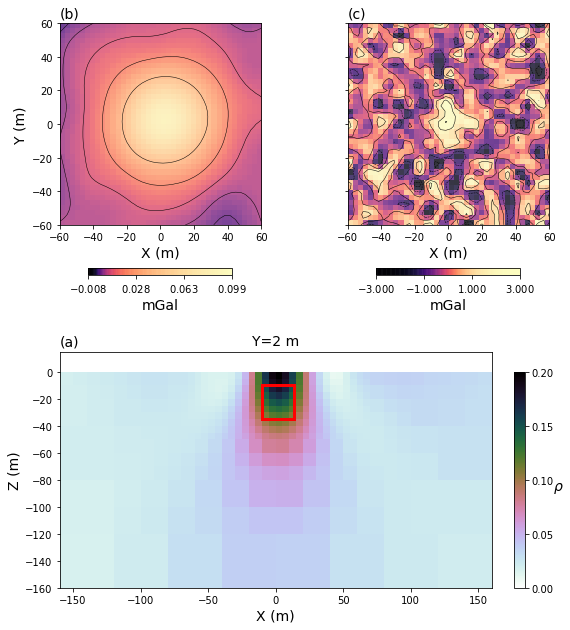

In [15]:
# Create sensitivity eights
wr = probGrav.getJtJdiag(np.ones(nC))**0.5
wr = (wr/np.max(wr))

# Create a regularization
reg_Simple_mod = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='component')
reg_Simple_mod.cell_weights = wr 

# Apply the 1/dx**2 to the gradient functions
reg_Simple_mod.alpha_s = 0
# for ii, objfct in enumerate(reg_Simple_mod.objfcts[1:]):
#     objfct.cell_weights /= mesh.h_gridded[actv, ii]**2.
reg_Simple_mod.mref = np.zeros(nC)


# Data misfit function
dmis = DataMisfit.l2_DataMisfit(surveyGrav)
dmis.W = 1./surveyGrav.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=-1., upper=1.,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg_Simple_mod, opt)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e+1)
chiTarget = Directives.TargetMisfit()
betaCool = Directives.BetaSchedule(coolingFactor = 2., coolingRate = 1)

update_Jacobi = Directives.UpdatePreconditioner()
inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, betaCool, chiTarget, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
mrec_Simple_mod = inv.run(m0)


plot_results(mrec_Simple_mod, figName="Grav_Inv_Simple_modified.png")

Still have a mesh independent result and length scales are out of the IRLS weights.

# Repeat inversion with mixed lp-norms

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.08e+06  6.16e+03  1.03e-06  6.16e+03    1.11e+02      0              
   1  5.39e+05  3.09e+03  7.80e-04  3.51e+03    1.07e+02      0              
   2  2.70e+05  2.60e+03  1.44e-03  2.99e+03    1.01e+02      0   Skip BFGS  
   3  1.35e+05  2.07e+03  2.86e-03  2.46e+03    9.81e+01      0   Skip BFGS  
   4  6.74e+04  1.51e+03  5.89e-03  1.90e+03    9.45e+01      0   Skip BFGS  
   5  3.37e+04  9.96e+02  1.13e-02  1.38e+03    9.00e+01      0   Skip BFGS  
   

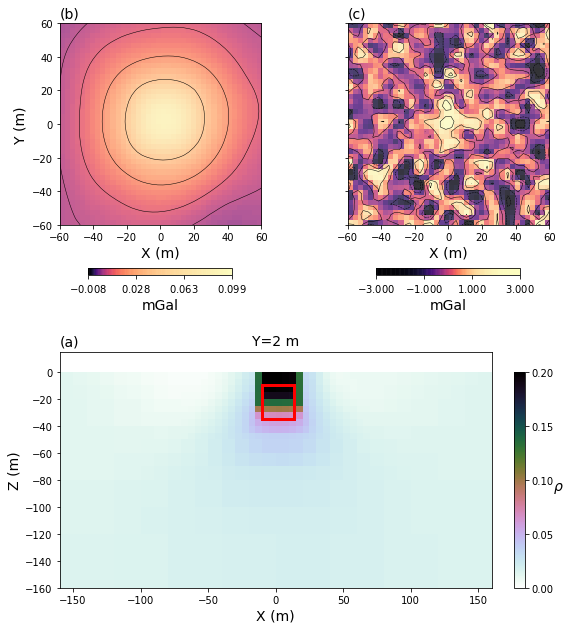

In [17]:
# Create sensitivity eights
wr = probGrav.getJtJdiag(np.ones(nC))**0.5
wr = (wr/np.max(wr))

# Create a regularization
reg_Simple_mod = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap, gradientType='component')
reg_Simple_mod.cell_weights = wr 

# Apply the 1/dx**2 to the gradient functions
# for ii, objfct in enumerate(reg_Simple_mod.objfcts[1:]):
#     objfct.cell_weights /= mesh.h_gridded[actv, ii]**2.
    
# Auto scale the components based on the core cell size
# reg_Simple_mod.alpha_x = mesh.h_gridded[actv, 0].min()**2.    
# reg_Simple_mod.alpha_y = mesh.h_gridded[actv, 1].min()**2. 
# reg_Simple_mod.alpha_z = mesh.h_gridded[actv, 2].min()**2.  

reg_Simple_mod.mref = np.zeros(nC)
reg_Simple_mod.norms = np.c_[2,0,0,0]

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(surveyGrav)
dmis.W = 1./surveyGrav.std

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=-1., upper=1.,
                                 maxIterLS=20, maxIterCG=20, tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg_Simple_mod, opt)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e+0)

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, betaSearch=False, maxIRLSiter=20)
update_Jacobi = Directives.UpdatePreconditioner()
inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, IRLS, update_Jacobi])

# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
mrec_Simple_mod_lp = inv.run(m0)


plot_results(mrec_Simple_mod_lp, figName="Grav_Inv_Simple_modified_l0l2.png")